<a href="https://colab.research.google.com/github/shashwat9kumar/ML-And-DataScience/blob/master/Tensorflow/05_transfer_learning_with_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow part 2: Fine Tuning

In [1]:
# Check if we're using a GUP
!nvidia-smi

Mon Jun 21 13:04:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper functions

In th previous notebooks, we've created a bunch of helper functions.

We could rewrite them all, but that is tedious


So, its a good idea to put functions in a script that you want to use  again in a script.
We've done that for some function: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-21 13:04:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-21 13:04:30 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

Note: If you're running this notebook in googlecollab, if the runtime disconnects, then you'll have to redownload the helper_functions.py by re-sunning the cells *above*

## Let's get some data

This time we're going to see how to use the pretrained model within the tf.keras.applications and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 clases of food

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-06-21 13:04:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   175MB/s    in 0.9s    

2021-06-21 13:04:33 (175 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Checkout how many images and subdirectories are in our dataset

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [6]:
# Creating traininbg and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE =(224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data

for images, labels in train_data_10_percent.take(1):
    print(images, labels)


tf.Tensor(
[[[[ 65.7602      55.7602      28.760202  ]
   [ 85.28571     78.28571     50.285717  ]
   [ 81.91327     74.91327     48.91327   ]
   ...
   [ 99.90284     90.33137     80.1171    ]
   [ 93.760086    83.760086    73.760086  ]
   [120.47522    110.47522    100.47522   ]]

  [[ 91.301025    81.301025    56.301025  ]
   [ 60.056118    52.19387     28.78061   ]
   [ 67.92347     59.923466    36.923466  ]
   ...
   [105.75566     96.18419     85.969925  ]
   [119.63737    109.63737     99.63737   ]
   [ 70.1075      60.1075      50.1075    ]]

  [[ 72.36735     61.36735     39.79592   ]
   [ 74.2398      66.2398      45.66837   ]
   [ 92.65816     84.65816     64.08673   ]
   ...
   [ 80.41272     70.84125     58.62698   ]
   [109.6483      99.6483      87.6483    ]
   [129.87741    119.8774     107.8774    ]]

  ...

  [[114.50039     80.50039     68.653435  ]
   [105.52099     72.505684    56.09237   ]
   [117.09771     84.883446    64.31197   ]
   ...
   [ 32.714417     7.142

In [11]:
# See an example of a batch of data

for images, labels in train_data_10_percent.take(1):
    print(len(images), labels)

32 tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 

## Model 0: building a transfer learning feature extraction model using a keras Functional AI

The sequential Api is straight-forward, it runs the layers in sequential order

But the functional API gives us more flexibility: https://www.tensorflow.org/guide/keras/functional

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # Because this model is originally trained on Imagenet its top layer is fitted for 1000 clases, and we want it to change to 10

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="Input Layer")

# 4. If using a model like Resnet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(input)
# Dont have to do for efficientnet, it is inbuilt for it if using from tf.keras.applications


# 5. Pass the inputs to base model 
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average Pool the output of the base model (aggregate the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Average_Pooling_layer")(x)
print(f"Shape after Global average pooling 2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation ="softmax", name="Output_Layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after Global average pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20210621-130444
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 305ms/step - loss: 1.9186 - accuracy: 0.3947 - val_loss: 1.3802 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 5s 202ms/step - loss: 1.1554 - accuracy: 0.7347 - val_loss: 0.9516 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - 5s 202ms/step - loss: 0.8324 - accuracy: 0.8227 - val_loss: 0.7688 - val_accuracy: 0.8076
Epoch 4/5
24/24 [==============================] - 5s 206ms/step - loss: 0.6848 - accuracy: 0.8427 - val_loss: 0.6755 - val_accuracy: 0.8240
Epoch 5/5
24/24 [==============================] - 5s 202ms/step - loss: 0.6006 - accuracy: 0.8627 - val_loss: 0.6123 - val_accuracy: 0.8503


In [13]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 0.6047 - accuracy: 0.8432


[0.6046938896179199, 0.8432000279426575]

In [14]:
# check the layers in the base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
# how about we get the summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [16]:
# How about the summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_Average_Pooling_layer (None, 1280)              0         
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


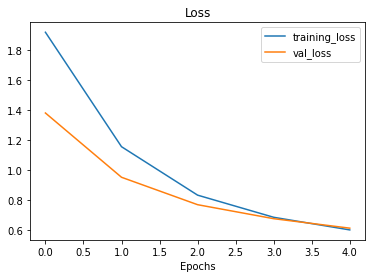

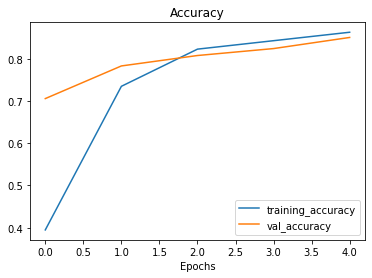

In [17]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base model` of shape (None, 7, 7, 1280)

But then it passes through Global AveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of(1,4,4,3) and pass it through GlobalAveragePooling2D

In [18]:
# Defining input shape
input_shape = (1,4,4,3)  # or 1,7,7,1280 as above (we're using smaller so it's easy to visualize)

# Create a random tensor
tf.random.set_seed(42)
input_tensor  =  tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

global_average_poolef_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled tensor:\n {global_average_poolef_tensor}\n")


# Check the shape of different tensors:
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D tensor: {global_average_poolef_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D tensor: (1, 3)


In [19]:
# Let's replicate the global Average Pool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [20]:
tf.keras.layers.GlobalMaxPooling2D()(input_tensor)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

on own

In [21]:
tf.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [22]:
first_reduction = tf.reduce_max(input_tensor, axis=[2])
first_reduction

<tf.Tensor: shape=(1, 4, 3), dtype=float32, numpy=
array([[[ 0.3274685 ,  0.539707  ,  1.6994323 ],
        [ 0.9058464 ,  0.29855987, -0.22561555],
        [ 0.77852213,  1.1603122 ,  0.97772694],
        [ 0.10815629,  0.88698614,  0.52744764]]], dtype=float32)>

In [23]:
tf.reduce_max(first_reduction, axis=[1])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

on own end

## Running a series of Transder Learning Experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it do with 1% of the training data ..how 'bout we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning with 100% of the training data with data augmentation


**Note**: thoroughout all experiments the same test dataset will be used to evaluate our model .. this ensures across evaluation metrics

### Getting and preprocessing data for model_1

In [24]:
# Download and unzip data - preprocessed from food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_1_percent.zip')

--2021-06-21 13:06:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   177MB/s    in 0.7s    

2021-06-21 13:06:04 (177 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [25]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [26]:
# How many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [27]:
# Set up data loaders
IMAGE_SIZE =(224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMAGE_SIZE,
                                                                           batch_size=BATCH_SIZE)  #default = 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layer inside

* `tf.keras.layers.experimental.preprocessing()`


The benefits of doing so are:
* The augmentaion will happen on a GPU and benefit on time saving
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere. (augmentaion doesn't happen during prediction)

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential(
    [
     preprocessing.RandomFlip("horizontal"),
     preprocessing.RandomRotation(0.2),
     preprocessing.RandomZoom(0.2),
     preprocessing.RandomHeight(0.2),
     preprocessing.RandomWidth(0.2)
     # preprocessing.Rescale(1/255.) # for models like resnet, effficientnet has it built in
    ], name ="data_augmentation"
)

### Visualize our data augmentaion layer and see what happens

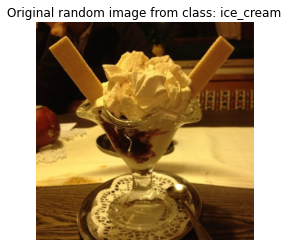

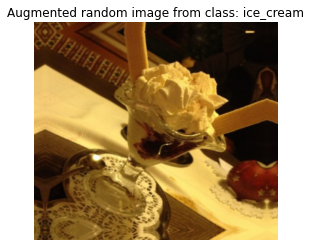

In [29]:
# View a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Now let's plot the augmented image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
# print(tf.squeeze(augmented_img))
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Mode 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [30]:
from tensorflow.keras import layers

In [31]:
# Setup the inpite shape and base model, freezing the base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Creating input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data aufmentaion Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs after they have been augmented
x = base_model(x, training=False)

# Pool the outputs of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer o as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Comile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Create some callbacks
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210621-130608


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 10s 3s/step - loss: 2.4521 - accuracy: 0.0714 - val_loss: 2.2398 - val_accuracy: 0.1316
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1639 - accuracy: 0.1714 - val_loss: 2.0985 - val_accuracy: 0.2566
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9466 - accuracy: 0.3286 - val_loss: 2.0014 - val_accuracy: 0.3355
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7502 - accuracy: 0.5714 - val_loss: 1.8991 - val_accuracy: 0.4211
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6764 - accuracy: 0.5857 - val_loss: 1.8107 - val_accuracy: 0.4539


Tad bit to note if in FunctionalApi we give a whole model we pass the previous layer in the first set of braces like whole_model(x) but if we are passing just a lyer we give the previous layer in the next set of brackets like layer()(x)

In [32]:
IMG_SIZE + (3,)

(224, 224, 3)

In [33]:
# Checkout model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [34]:
# Evaluate on full test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 103ms/step - loss: 1.8282 - accuracy: 0.4524


[1.8281561136245728, 0.45239999890327454]

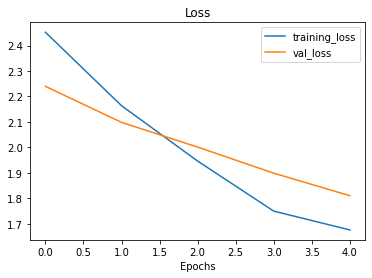

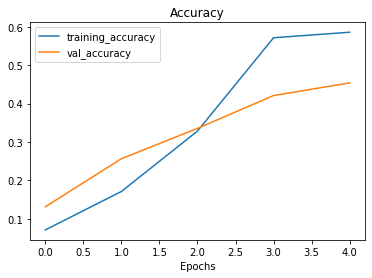

In [35]:
# How does the model on 1% data with data augmentsation's loss curve look like

plot_loss_curves(history_1_percent)

On own

In [36]:
# Creating traininbg and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [37]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [38]:
train_data_10_percent = image_dataset_from_directory(train_dir,
                                                     image_size=(224,224),
                                                     batch_size=32,
                                                     label_mode="categorical")

Found 750 files belonging to 10 classes.


In [39]:
data_aug = tf.keras.Sequential(
    [
     preprocessing.RandomFlip("horizontal"),
     preprocessing.RandomRotation(0.2),
     preprocessing.RandomZoom(0.2),
     preprocessing.RandomHeight(0.2),
     preprocessing.RandomWidth(0.2)
    ], name="data_augmentation"
)

In [40]:
base_model_needed = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_needed.trainable=False

inputs = layers.Input(shape=(224,224,3), name="Input_layer")
x = data_aug(inputs)
x = base_model_needed(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, name="Output_layer", activation="softmax")(x)

model_2_on_own = tf.keras.Model(inputs, outputs)

In [41]:
model_2_on_own.compile(loss="categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

histroy_2_on_own = model_2_on_own.fit(train_data_10_percent,
                   epochs=5,
                   steps_per_epoch=len(train_data_10_percent),
                   validation_data=test_data,
                   validation_steps=int(0.25 * len(test_data)),
                   callbacks= [create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="10_percent_data_aug_on_own")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug_on_own/20210621-130649
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 20s 629ms/step - loss: 1.9952 - accuracy: 0.3080 - val_loss: 1.5216 - val_accuracy: 0.6234
Epoch 2/5
24/24 [==============================] - 11s 468ms/step - loss: 1.3803 - accuracy: 0.6267 - val_loss: 1.0670 - val_accuracy: 0.7714
Epoch 3/5
24/24 [==============================] - 10s 403ms/step - loss: 1.0613 - accuracy: 0.7413 - val_loss: 0.8721 - val_accuracy: 0.7944
Epoch 4/5
24/24 [==============================] - 9s 369ms/step - loss: 0.8837 - accuracy: 0.7827 - val_loss: 0.7773 - val_accuracy: 0.7977
Epoch 5/5
24/24 [==============================] - 9s 340ms/step - loss: 0.7833 - accuracy: 0.8013 - val_loss: 0.6982 - val_accuracy: 0.8191


In [42]:
model_2_on_own.evaluate(test_data)

79/79 [==============================] - 8s 103ms/step - loss: 0.6812 - accuracy: 0.8244


[0.6812317371368408, 0.824400007724762]

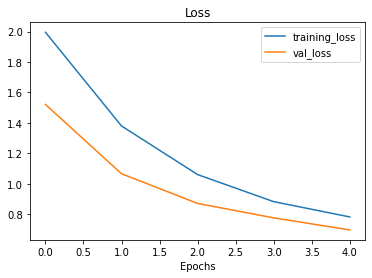

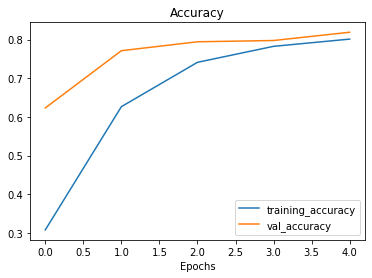

In [43]:
plot_loss_curves(histroy_2_on_own)

On own end

## Model 2: Feature Extraction model with transfer learning on 10 percent of data with data augmentation

In [44]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [45]:
# Set up data inputs 
IMG_SIZE = (224,224)
BATCH_SIZE= 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [46]:
# Create model2 with data augmentaion built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation
data_augmentaion = Sequential(
    [
     preprocessing.RandomFlip("horizontal"),
     preprocessing.RandomRotation(0.2),
     preprocessing.RandomZoom(0.2),
     preprocessing.RandomHeight(0.2),
     preprocessing.RandomWidth(0.2)
     # preprocessing.Rescaling(1/255.)
    ], name="data_augmentation"
)

# Set up input shape
input_shape = (224,224,3)

# create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the inputs and outputs
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # The training is off that is the model remains in inference mode and the batchnorm layers don't get updated
# now compressing the multidimensional tensor into a feature vector
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)


# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2d (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a model_checkpoint callback


The ModelCheckpointCallback saves intermediary models (the full model or the weights) during training. this is useful when training takes a lomg time and we want to come bacl to it later

In [48]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.cpkt"

# Create a modelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # save every epoch
                                                         verbose=1)

### Fit model 2 passing in the model check point callback

In [49]:
# Fit the model saving checkpints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data= test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210621-130803
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 16s 451ms/step - loss: 2.0504 - accuracy: 0.3107 - val_loss: 1.4863 - val_accuracy: 0.6234

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.cpkt
Epoch 2/5
24/24 [==============================] - 10s 394ms/step - loss: 1.3762 - accuracy: 0.6547 - val_loss: 1.0972 - val_accuracy: 0.7500

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.cpkt
Epoch 3/5
24/24 [==============================] - 9s 372ms/step - loss: 1.0687 - accuracy: 0.7427 - val_loss: 0.8733 - val_accuracy: 0.7845

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.cpkt
Epoch 4/5
24/24 [==============================] - 8s 333ms/step - loss: 0.9096 - accuracy: 0.7693 - val_loss: 0.7614 - val_accuracy: 0.8059

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.cpkt
Epoch 5/5
24/24 [==============================] - 9s 383ms/step - loss: 0.8105 - accuracy: 0.7960 - val_los

In [50]:
# Ehat were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 9s 103ms/step - loss: 0.6047 - accuracy: 0.8432


[0.6046940088272095, 0.8432000279426575]

In [51]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 104ms/step - loss: 0.7041 - accuracy: 0.8168


[0.7040771245956421, 0.8167999982833862]

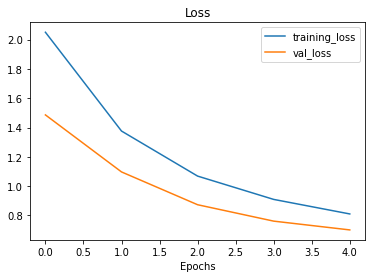

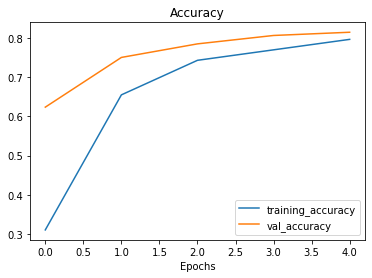

In [52]:
# Plot model_loss curve
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returna a model to a specific checkpoint.

In [53]:
# Load in saved model weights and evaluate the model

## Model 2 was evaluated earlier. so if we load it again and then it must give the same results

model_2.load_weights(checkpoint_path)

In [54]:
# Evaluate model_2 with loaded weights

loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.7041 - accuracy: 0.8168


In [55]:
loaded_weights_model_results

[0.7040773630142212, 0.8167999982833862]

In [56]:
results_10_percent_data_aug

[0.7040771245956421, 0.8167999982833862]

In [57]:
loaded_weights_model_results == results_10_percent_data_aug  ## This is because of how computers store numbers internaly

False

In [58]:
# check to see if loaded model results are close to the previous evaluated results

import numpy as np
np.isclose(np.array(loaded_weights_model_results), np.array(results_10_percent_data_aug))

array([ True,  True])

In [59]:
# check the difference between 2 results

print(np.array(loaded_weights_model_results) - np.array(results_10_percent_data_aug))

[2.38418579e-07 0.00000000e+00]


## Model 3: Fine tuning an existing model with 10 percent of training data


**Note**: Fine tuning usually works best **after** training after training a feature extraction model for a few epochs with large amounts of custom data

In [60]:
# Layers in loaded model

# Model 3 is a fine tuned version of model 2

model_2.layers

In [61]:
# Are these layers trainable?

for layer in model_2.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0bce318910> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f0c46dee850> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f0a6bb7f490> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f0a6bb1f3d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0a6bbf39d0> True


In [62]:
for i, layer in enumerate( model_2.layers[2].layers):
    print(i, layer.name, "\t\t\t\t",layer.trainable)

0 input_4 				 False
1 rescaling_3 				 False
2 normalization_3 				 False
3 stem_conv_pad 				 False
4 stem_conv 				 False
5 stem_bn 				 False
6 stem_activation 				 False
7 block1a_dwconv 				 False
8 block1a_bn 				 False
9 block1a_activation 				 False
10 block1a_se_squeeze 				 False
11 block1a_se_reshape 				 False
12 block1a_se_reduce 				 False
13 block1a_se_expand 				 False
14 block1a_se_excite 				 False
15 block1a_project_conv 				 False
16 block1a_project_bn 				 False
17 block2a_expand_conv 				 False
18 block2a_expand_bn 				 False
19 block2a_expand_activation 				 False
20 block2a_dwconv_pad 				 False
21 block2a_dwconv 				 False
22 block2a_bn 				 False
23 block2a_activation 				 False
24 block2a_se_squeeze 				 False
25 block2a_se_reshape 				 False
26 block2a_se_reduce 				 False
27 block2a_se_expand 				 False
28 block2a_se_excite 				 False
29 block2a_project_conv 				 False
30 block2a_project_bn 				 False
31 block2b_expand_conv 				 False
32 block2b_expand_bn 

In [63]:
# How many trainable variables are there in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [64]:
# to begin fine tuning, let's start by setting tehe last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10

for layer in base_model.layers[:-10]:
    layer.trainable = False


# We have to recompile our model every time we make a change

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # a rule of thumb is to lower a learning rate by 10X once we fine tune. Because the model has already learned some weights we do not want to change it too much
                metrics=["accuracy"])

**Note:** When fine tuning it is best practice to lower the learning rate by some amounts. How much? This is a hyperparameter you can fine tune and experiment with. A rule of thumb is atlear 10X (but different sources will claim other values)


A resource on this is the ULMFit paper for fine tuning: https://arxiv.org/abs/1801.06146

In [65]:
# Check which layers are trainable

for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, "\t\t\t\t",layer.trainable)

0 input_4 				 False
1 rescaling_3 				 False
2 normalization_3 				 False
3 stem_conv_pad 				 False
4 stem_conv 				 False
5 stem_bn 				 False
6 stem_activation 				 False
7 block1a_dwconv 				 False
8 block1a_bn 				 False
9 block1a_activation 				 False
10 block1a_se_squeeze 				 False
11 block1a_se_reshape 				 False
12 block1a_se_reduce 				 False
13 block1a_se_expand 				 False
14 block1a_se_excite 				 False
15 block1a_project_conv 				 False
16 block1a_project_bn 				 False
17 block2a_expand_conv 				 False
18 block2a_expand_bn 				 False
19 block2a_expand_activation 				 False
20 block2a_dwconv_pad 				 False
21 block2a_dwconv 				 False
22 block2a_bn 				 False
23 block2a_activation 				 False
24 block2a_se_squeeze 				 False
25 block2a_se_reshape 				 False
26 block2a_se_reduce 				 False
27 block2a_se_expand 				 False
28 block2a_se_excite 				 False
29 block2a_project_conv 				 False
30 block2a_project_bn 				 False
31 block2b_expand_conv 				 False
32 block2b_expand_bn 

In [66]:
# Now we've unfrozen some of the layers to the top, how many trainable variables are there
print(len(model_2.layers[2].trainable_variables))

10


In [67]:
print(len(model_2.trainable_variables))

12


In [68]:
model_2.layers[2].trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [69]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model 2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               steps_per_epoch=len(train_data_10_percent),
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],  ## Start training from the previous model left
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_ten")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_ten/20210621-130932
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 18s 486ms/step - loss: 0.6645 - accuracy: 0.8000 - val_loss: 0.5502 - val_accuracy: 0.8092
Epoch 6/10
24/24 [==============================] - 8s 339ms/step - loss: 0.5529 - accuracy: 0.8320 - val_loss: 0.5604 - val_accuracy: 0.8207
Epoch 7/10
24/24 [==============================] - 9s 336ms/step - loss: 0.4758 - accuracy: 0.8547 - val_loss: 0.5678 - val_accuracy: 0.8043
Epoch 8/10
24/24 [==============================] - 8s 327ms/step - loss: 0.4741 - accuracy: 0.8520 - val_loss: 0.5362 - val_accuracy: 0.8141
Epoch 9/10
24/24 [==============================] - 9s 361ms/step - loss: 0.4006 - accuracy: 0.8760 - val_loss: 0.5105 - val_accuracy: 0.8273
Epoch 10/10
24/24 [==============================] - 8s 339ms/step - loss: 0.3588 - accuracy: 0.8907 - val_loss: 0.5097 - val_accuracy: 0.8306


In [70]:
# Evaluate the fine-tuned model (mode 3 which is model 2 only)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 103ms/step - loss: 0.4987 - accuracy: 0.8336


In [71]:
results_10_percent_data_aug

[0.7040771245956421, 0.8167999982833862]

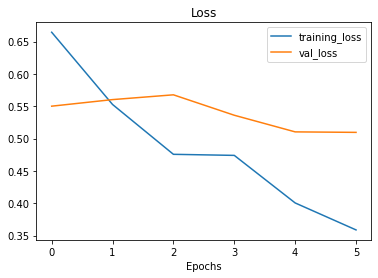

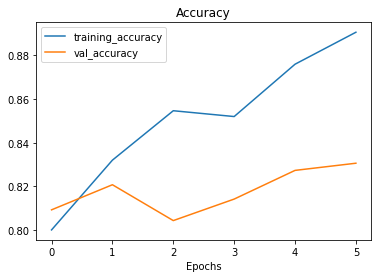

In [72]:
# Check out the loss curves of fine tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curve` function works great with models which have only been fit once. We want something to compare one series of funning `fit()` with another (eg: before and after fine tuning)

In [73]:
# lets create a function to compare training histories

def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compare two Tensorflow Histroy objevcts
    """

    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]


    # Make plots for Accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and validation Accuracy")

    # Make plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and validation Loss")

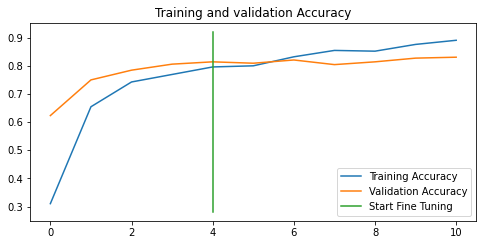

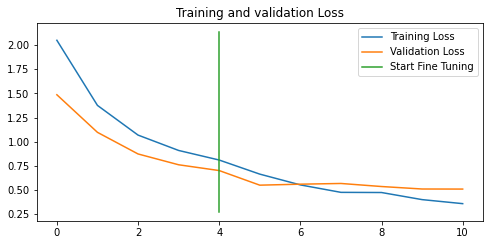

In [74]:
compare_histories(history_10_percent_data_aug, history_fine_10_percent_data_aug)

## Model 4: Fine tuning an existing model on all of the data

In [76]:
# Download and unzip of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-06-21 13:14:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.251.2.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   257MB/s    in 1.9s    

2021-06-21 13:15:00 (257 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [77]:
# Set up training and test dir

train_dir_all_data = "10_food_classes_all_data/train"
test_dir_all_data = "10_food_classes_all_data/test"

In [78]:
# Find out how many images are we working with now
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [79]:
# Set up data inputs
import tensorflow as tf

IMG_SIZE=(224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 image_size=IMG_SIZE,
                                                                                 label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_all_data,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test data set we've loaded is the same as what we've been usin for all previous experiments

Lets verify this .....

In [80]:
# Evaluate model 2 with the test data
model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.4987 - accuracy: 0.8336


[0.49868011474609375, 0.8335999846458435]

In [81]:
results_fine_tune_10_percent

[0.4986799657344818, 0.8335999846458435]

To train a fine_tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [82]:
# Load weights from checkpoint, that way we can fine-tune from the
# same stage as the 10-percent data model was fine tuned from

model_2.load_weights(checkpoint_path)

In [83]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 9s 103ms/step - loss: 0.7041 - accuracy: 0.8168


[0.7040771842002869, 0.8167999982833862]

In [84]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.7040771245956421, 0.8167999982833862]

All we've done above is:

 1. Trained a feature extraction transfer learning model for 5 epochs with 10% of data with data augmentation (model_2) and saved the model's weight using `ModelCheckPoint` callback
 2.  Fine tuned the same model with top 10 layers of base model unfrozen (model_3) with 10 percent of the total data
 3. Saved the results and training logs each time
 4. Reload the model from step 1 to do the same steps as step 2 except this time we are going to use all of the data (model_4)

In [86]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2d True
4 output_layer True


In [90]:
# Lets drill deep into the base model a(efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name,"\t\t\t", layer.trainable)


0 input_4 			 False
1 rescaling_3 			 False
2 normalization_3 			 False
3 stem_conv_pad 			 False
4 stem_conv 			 False
5 stem_bn 			 False
6 stem_activation 			 False
7 block1a_dwconv 			 False
8 block1a_bn 			 False
9 block1a_activation 			 False
10 block1a_se_squeeze 			 False
11 block1a_se_reshape 			 False
12 block1a_se_reduce 			 False
13 block1a_se_expand 			 False
14 block1a_se_excite 			 False
15 block1a_project_conv 			 False
16 block1a_project_bn 			 False
17 block2a_expand_conv 			 False
18 block2a_expand_bn 			 False
19 block2a_expand_activation 			 False
20 block2a_dwconv_pad 			 False
21 block2a_dwconv 			 False
22 block2a_bn 			 False
23 block2a_activation 			 False
24 block2a_se_squeeze 			 False
25 block2a_se_reshape 			 False
26 block2a_se_reduce 			 False
27 block2a_se_expand 			 False
28 block2a_se_excite 			 False
29 block2a_project_conv 			 False
30 block2a_project_bn 			 False
31 block2b_expand_conv 			 False
32 block2b_expand_bn 			 False
33 block2b_expand_acti

In [91]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [92]:
# Continue to train and fine tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           steps_per_epoch=len(train_data_10_classes_full),
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210621-141344
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 50s 191ms/step - loss: 0.7261 - accuracy: 0.7613 - val_loss: 0.4930 - val_accuracy: 0.8438
Epoch 6/10
235/235 [==============================] - 55s 232ms/step - loss: 0.5836 - accuracy: 0.8128 - val_loss: 0.4107 - val_accuracy: 0.8668
Epoch 7/10
235/235 [==============================] - 51s 214ms/step - loss: 0.5195 - accuracy: 0.8289 - val_loss: 0.4010 - val_accuracy: 0.8668
Epoch 8/10
235/235 [==============================] - 50s 211ms/step - loss: 0.4673 - accuracy: 0.8499 - val_loss: 0.3685 - val_accuracy: 0.8832
Epoch 9/10
235/235 [==============================] - 44s 187ms/step - loss: 0.4392 - accuracy: 0.8553 - val_loss: 0.3860 - val_accuracy: 0.8717
Epoch 10/10
235/235 [==============================] - 45s 190ms/step - loss: 0.4139 - accuracy: 0.8663 - val_loss: 0.3744 - val_accuracy: 0.8750


In [93]:
# Lets evaluate on all of the test_data

results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.3372 - accuracy: 0.8896


In [94]:
results_fine_tune_full_data

[0.33723554015159607, 0.8895999789237976]

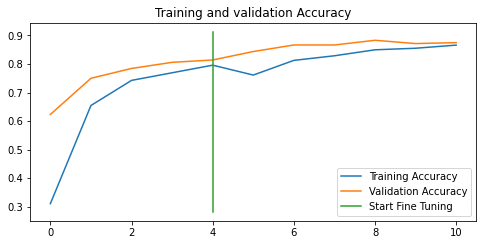

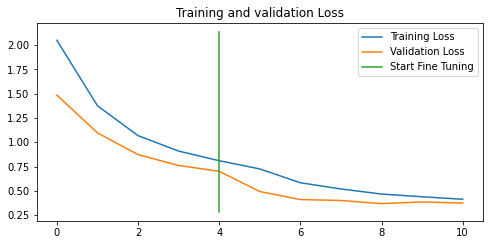

In [95]:
# How did fine tuning go with more data
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_classes_full)

# Viewing our experiments data on TensorBoard

**Note**: Anything uploaded to TensorBoard.dev is going to be public. So if you have private data, do not share it (or delete it quickly)

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be around 4 models)
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./transfer_learning \
 --name "Transfer Learning Experiments with 10 Food 101 classes" \
 --description "A series of transfer learning experiments with varying amounts of changes" \
 --one_shot # exit the uploader once its finished uploading

The Tensorboard experiments are availabe at : https://tensorboard.dev/experiment/YMOqI1cpQRKPDgi9iWwK8Q/

In [99]:
!tensorboard dev list

2021-06-21 14:38:02.367843: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/YMOqI1cpQRKPDgi9iWwK8Q/
	Name                 Transfer Learning Experiments with 10 Food 101 classes
	Description          A series of transfer learning experiments with varying amounts of changes
	Id                   YMOqI1cpQRKPDgi9iWwK8Q
	Created              2021-06-21 14:31:38 (6 minutes ago)
	Updated              2021-06-21 14:31:44 (6 minutes ago)
	Runs                 12
	Tags                 5
	Scalars              192
	Tensor bytes         0
	Binary object bytes  5068395
https://tensorboard.dev/experiment/hK1Y7cXPRpqBOzIA3jpMPw/
	Name                 EfficientNetB0 vs ResNet50V2
	Description           Compari

In [ ]:
# To delete an experiment 
# !tensorboard dev delete --experiment_id YMOqI1cpQRKPDgi9iWwK8Q 